## Simple AI Agent using LangGraph

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["PINECONE_API_KEY"]=os.getenv("PINECONE_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"

In [3]:
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embedding = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

d:\Agentic_AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Retriever Setup

In [5]:
pinecone_api_key = os.environ["PINECONE_API_KEY"]

In [6]:
from pinecone import Pinecone
pc = Pinecone(api_key=pinecone_api_key)

In [7]:
index_name = "nism-rag"
index = pc.Index(index_name)

In [8]:
from langchain_pinecone import PineconeVectorStore
vector_store = PineconeVectorStore(index=index,embedding=embedding)

retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs = {"k":5}
)

In [9]:
result = retriever.invoke("what is hammer pattern?")
result

[Document(id='69fa8346-212a-4691-91ff-ad9a78f01cd7', metadata={'creationdate': '2013-01-10T16:57:44+05:30', 'creator': 'PyPDF', 'moddate': '2013-08-12T18:41:56+05:30', 'page': 2.0, 'page_label': '3', 'producer': 'Acrobat Distiller 7.0 (Windows)', 'source': 'C:\\Users\\srich\\Downloads\\TA_wrkbk.pdf', 'title': 'untitled', 'total_pages': 172.0}, page_content='2.2.1.1 Hammer ............................................................................21\n  2.2.1.2 Hanging man ......................................................................22\n  2.2.1.3 Shooting star and inverted hammer .......................................23\n 2.2.2 Two candle pattern ............................................................................26\n  2.2.2.1 Bullish engulﬁ  ng ..................................................................26\n  2.2.2.2 Bearish engulﬁ  ng ................................................................28\n  2.2.2.3 Piercing .........................................

## Search Tool Setup

In [10]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [11]:
search_tool.invoke("warren buffet")

'Warren Buffett (born August 30, 1930, Omaha, Nebraska) is an American businessman and philanthropist, widely considered the most successful investor of the 20th and early 21st centuries, having defied prevailing investment trends to amass a personal fortune of more than $100 billion. Warren Buffett just changed how his considerable fortune will be spent following his death. Buffett, 93, the chairman of Berkshire Hathaway, told the Wall Street Journal he has again re-worked his ... Learn how Warren Buffett became the "Oracle of Omaha" and one of the richest men in the world. Discover his early life, education, mentors, investments, philanthropy and tips for value investors. Warren Buffett\'s Berkshire Hathaway succession announcement offers couples key lessons on planning for loss, household roles, and longevity in retirement. By Joseph Coughlin Senior Contributor ... Warren Buffett recently announced he\'s stepping down as Berkshire Hathaway\'s CEO at the end of this year — but he may

## LLM Setup

In [12]:
from langchain_groq import ChatGroq
validation_model = ChatGroq(model="llama-3.3-70b-versatile")

In [13]:
validation_model.invoke("what is genai")

AIMessage(content='GenAI is a term that refers to General Artificial Intelligence or General-Purpose Artificial Intelligence. It is a type of artificial intelligence that is designed to be versatile and able to perform a wide range of tasks, similar to human intelligence.\n\nGenAI is a hypothetical AI system that possesses the ability to:\n\n1. **Learn**: Acquire knowledge and skills from various sources, including data, experience, and feedback.\n2. **Reason**: Draw inferences, make decisions, and solve problems using logical and analytical thinking.\n3. **Understand**: Comprehend natural language, perceive the environment, and recognize patterns and relationships.\n4. **Apply**: Use knowledge and skills to perform tasks, adapt to new situations, and transfer learning to new domains.\n\nThe goals of GenAI research are to create an AI system that can:\n\n1. **Mimic human cognition**: Replicate human thought processes, including reasoning, problem-solving, and decision-making.\n2. **Exc

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm_model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

## Node, Router Setup

In [15]:
import operator
from typing import List
from pydantic import BaseModel,Field
from langchain.prompts import PromptTemplate
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [16]:
class TopicSelection(BaseModel):
    topic: str = Field(description="selected topic")
    reason: str = Field(description="reason behind the topic selection")

In [17]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelection)

In [18]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [19]:
def supervisor_node(state: AgentState):
    print("--- Supervisor ---")
    user_query = state["messages"][0]

    template = """ Your task is to classify the user query into three of the following categories [Stock,Web,LLM].
    Stock: if the user query is related to stock market then put it in this category.
    Web: if the user query need web search then put it in this category.
    LLM: If the user query can be answered using only LLM then put it in this category.

    user_query: {user_query}
    {format_instructions} 
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["user_query"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | llm_model | parser

    response = chain.invoke({"user_query": user_query})
    print("parsed response: ",response)

    return {"messages": [response.topic]}

In [20]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [21]:
def rag_node(state: AgentState):
    print("--- RAG ---")
    query = state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
            If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | llm_model
        | StrOutputParser()
    )

    result = rag_chain.invoke(query)
    return {"messages": [result]}

In [22]:
def web_node(state: AgentState):
    print("--- WEB ---")
    query = state["messages"][0]

    response = search_tool.invoke(query)

    return {"messages": [response]}

In [23]:
def llm_node(state: AgentState):
    print("--- LLM ---")
    query = state["messages"][0]
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + query
    response = llm_model.invoke(complete_query)
    return {"messages": [response.content]}

In [24]:
def validation_node(state: AgentState):
    user_query = state["messages"][0]
    system_response = state["messages"][-1]

    template = """ You are a validator for my ai agent, your task is to compare the user query with the system response and check for the relevancy 
    between the user query and system response and provide a score between 0-10. Keep the threshold value at 7, if the value is above or equal to 7 
    then produce result as approved or else denied. 
    Note: your output should be either approved or Denied
    user query = {user_query}
    system response = {system_response}
    """

    prompt = PromptTemplate(
        template=template,
        input_variable=["user_query","system_response"]
    )

    chain = prompt | validation_model 
    res = None
    try:
        response = chain.invoke({"user_query": user_query, "system_response": system_response})
        res = "Approved" if "approved" in response.content.lower() else "Denied"
    except Exception as e:
        print("Validation failed:", e)
        res = "Denied"

    return {"messages": [res]}
    

In [25]:
def router(state: AgentState):
    print("--- Router ---")

    last_message = state["messages"][-1]
    print("last message: ",last_message)

    if "stock" in last_message.lower():
        return "RAG call"
    elif "web" in last_message.lower():
        return "WEB call"
    else:
        return "LLM call"

In [26]:
def validation_router(state: AgentState):
    print("--- Validation Router ---")

    last_message = state["messages"][-1]
    print("Validation report: ",last_message)

    if "approved" in last_message.lower():
        return "Approved"
    else:
        return "Denied"



In [27]:
def end_action(state):
    final_answer = state["messages"][2]
    print("Final Answer: ",final_answer)
    print("Workflow completed.")
    return {"messages": [state["messages"][-1]]}

## Graph Building

In [28]:
from langgraph.graph import StateGraph,END

workflow = StateGraph(AgentState)

In [29]:
workflow.add_node("Supervisor",supervisor_node)
workflow.add_node("RAG",rag_node)
workflow.add_node("WEB",web_node)
workflow.add_node("LLM",llm_node)
workflow.add_node("Validation",validation_node)

In [30]:
workflow.add_node("END",end_action)

In [31]:
workflow.set_entry_point("Supervisor")

In [32]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG call": "RAG",
        "LLM call": "LLM",
        "WEB call": "WEB"
    }
)

In [33]:
workflow.add_edge("LLM","Validation")
workflow.add_edge("RAG","Validation")
workflow.add_edge("WEB","Validation")

In [34]:
workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "Approved": "END",
        "Denied": "Supervisor"
    }
)

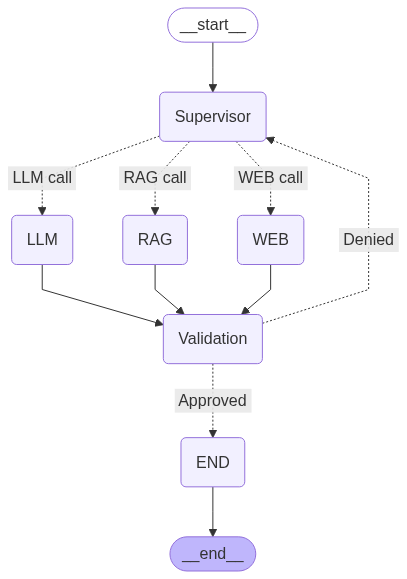

In [35]:
app = workflow.compile()
app

In [36]:
state={"messages": ["hi"]}
app.invoke(state)

--- Supervisor ---
parsed response:  topic='LLM' reason='The query "hi" is a simple greeting that does not require stock market data, web search, or complex reasoning; an LLM can handle it by providing a simple response like "Hello!"'
--- Router ---
last message:  LLM
--- LLM ---
--- Validation Router ---
Validation report:  Approved
Final Answer:  Hi there!
Workflow completed.


{'messages': ['hi', 'LLM', 'Hi there!', 'Approved', 'Approved']}

In [39]:
state={"messages": ["latest global news?"]}
app.invoke(state)

--- Supervisor ---
parsed response:  topic='Web' reason="The query 'latest global news?' requires accessing and processing information from various news sources, which necessitates a web search."
--- Router ---
last message:  Web
--- WEB ---
--- Validation Router ---
Validation report:  Approved
Final Answer:  Reuters.com is your online source for the latest world news stories and current events, ensuring our readers up to date with any breaking news developments Get the latest international news and world events from Asia, Europe, the Middle East, and more. See world news photos and videos at ABCNews.com NPR world news, international art and culture, world business and financial markets, world economy, and global trends in health, science and technology. Subscribe to the World Story of the Day ... The New York Times seeks the truth and helps people understand the world. With 1,700 journalists reporting from more than 150 countries, we provide live updates, investigations, photos and v

{'messages': ['latest global news?',
  'Web',
  "Reuters.com is your online source for the latest world news stories and current events, ensuring our readers up to date with any breaking news developments Get the latest international news and world events from Asia, Europe, the Middle East, and more. See world news photos and videos at ABCNews.com NPR world news, international art and culture, world business and financial markets, world economy, and global trends in health, science and technology. Subscribe to the World Story of the Day ... The New York Times seeks the truth and helps people understand the world. With 1,700 journalists reporting from more than 150 countries, we provide live updates, investigations, photos and video ... World News: Get Latest and breaking news from World. Today's Top International News Headlines, news on politics, Business, Crime, Sports and Current Affairs.",
  'Approved',
  'Approved']}

In [38]:
state={"messages": ["what is hanging man pattern"]}
app.invoke(state)

--- Supervisor ---
parsed response:  topic='Stock' reason='The "hanging man pattern" is a candlestick pattern used in technical analysis of stock charts.'
--- Router ---
last message:  Stock
--- RAG ---
--- Validation Router ---
Validation report:  Approved
Final Answer:  A hanging man is a one-candle candlestick pattern that appears during an uptrend.  It has a long lower shadow and a small real body, which can be black or white, signifying a potential top reversal needing confirmation.  Confirmation typically requires a higher open and close the following trading day.
Workflow completed.


{'messages': ['what is hanging man pattern',
  'Stock',
  'A hanging man is a one-candle candlestick pattern that appears during an uptrend.  It has a long lower shadow and a small real body, which can be black or white, signifying a potential top reversal needing confirmation.  Confirmation typically requires a higher open and close the following trading day.',
  'Approved',
  'Approved']}